# Integration of data from the Census

The Census is a versioned container for the single-cell data hosted at [CELLxGENE Discover](https://cellxgene.cziscience.com/). The Census utilizes [SOMA](https://github.com/single-cell-data/SOMA/blob/main/abstract_specification.md) powered by [TileDB](https://tiledb.com/products/tiledb-embedded) for storing, accessing, and efficiently filtering data.

The Census contains data from multiple studies providing an opportunity to perform inter-dataset analysis. To this end integration of data has to be performed first to account for batch effects.

This notebook provides a demonstration for integrating two Census datasets using [`scvi-tools`](https://docs.scvi-tools.org/en/stable/index.html). The goal is not to provide an exhaustive guide on proper integration, but to showcase what information in the Census can inform data integration.

We will go over the following:

1. Finding and fetching data from mouse liver (10X Genomics and Smart-Seq2).
1. Gene-length normalization of Smart-Seq2 data.
1. Integration with `scvi-tools`.
   1. Inspecting data prior to integration.
   1. Integration with batch defined as `dataset_id`.
   1. Integration with batch defined as `dataset_id` + `donor_id`.
   1. Integration with batch defined as `dataset_id` + `donor_id` + `assay_ontology_term_id` + `suspension_type`.

## Finding and fetching data from mouse liver

Let's load all modules needed for this notebook.

In [1]:
import cellxgene_census
import scanpy as sc
import numpy as np
import scvi
from scipy.sparse import csr_matrix

Global seed set to 0
/home/bruce/projects/cellxgene-census/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now we can open the Census, if you are not familiar with the basics of the Census API you should take a look at the notebook "Learning about the CELLxGENE Census" at `comp_bio_census_info.ipynb`.

In [2]:
census = cellxgene_census.open_soma(census_version="latest")

In this notebook we will use Tabula Muris Senis data from the liver as it contains cells from both 10X Genomics and Smart-Seq2 technologies.

Let's query the `datasets` table of the Census by filtering on `collection_name` for "Tabula Muris Senis" and `dataset_title` for "liver". 

In [3]:
census_datasets = (
    census["census_info"]["datasets"].read(value_filter="collection_name == 'Tabula Muris Senis'").concat().to_pandas()
)
tabula_liver = census_datasets["dataset_title"].str.contains("liver", case=False)
census_datasets.loc[tabula_liver,]

,soma_joinid,collection_id,collection_name,collection_doi,dataset_id,dataset_title,dataset_h5ad_path,dataset_total_cell_count
6,335,0b9d8a04-bb9d-44da-aa27-705bb65b54eb,Tabula Muris Senis,10.1038/s41586-020-2496-1,6202a243-b713-4e12-9ced-c387f8483dea,Liver - A single-cell transcriptomic atlas cha...,6202a243-b713-4e12-9ced-c387f8483dea.h5ad,7294
14,343,0b9d8a04-bb9d-44da-aa27-705bb65b54eb,Tabula Muris Senis,10.1038/s41586-020-2496-1,4546e757-34d0-4d17-be06-538318925fcd,Liver - A single-cell transcriptomic atlas cha...,4546e757-34d0-4d17-be06-538318925fcd.h5ad,2859


Now we can use the values from `dataset_id` to query and load an AnnData object with all the cells from those datasets. 

In [4]:
tabula_muris_liver_ids = ["4546e757-34d0-4d17-be06-538318925fcd", "6202a243-b713-4e12-9ced-c387f8483dea"]

adata = cellxgene_census.get_anndata(
    census, organism="Mus musculus", obs_value_filter=f"dataset_id in {tabula_muris_liver_ids}"
)

Close the census

In [5]:
census.close()
del census

We can check the cell counts for both 10X Genomics and Smart-Seq2 data by looking at `obs["assay"]`.

In [6]:
adata.obs.assay.value_counts()

10x 3' v2     7294
Smart-seq2    2859
Name: assay, dtype: int64

##  Gene-length normalization of Smart-Seq2 data.

Smart-seq2 read counts have to be normalized by gene length. For full details on gene-length normalization take a look at the notebook "Normalizing full-length gene sequencing data from the Census" at `comp_bio_normalizing_full_gene_sequencing.ipynb`.

Let's first get the gene lengths from `var.feature_length`.

In [7]:
smart_seq_gene_lengths = adata.var[["feature_length"]].to_numpy()

Now we create a copy of a slice of the expression matrix only containing Smart-Seq2 data.

In [8]:
smart_seq_index = np.where(adata.obs.assay == "Smart-seq2")[0]
smart_seq_index
smart_seq_X = adata.X[smart_seq_index, :].copy()

We proceed to normalize it using the gene lengths.

In [9]:
smart_seq_X = csr_matrix((smart_seq_X.T / smart_seq_gene_lengths).T)
smart_seq_X = smart_seq_X.ceil()

And now we put it back into the AnnData object.

In [10]:
adata.X[smart_seq_index, :] = smart_seq_X

## Integration with scvi-tools

From its documentation `scvi-tools` is described as a package for end-to-end analysis of single-cell omics data primarily developed and maintained by the Yosef Lab at UC Berkeley.

Here we will use the "single-cell Variational Inference" model or scVI which uses a deep generative model for the integration of spatial transcriptomic data and scRNA-seq data.

For comprehensive usage and best practices of scVI please refer to the [doc site](https://docs.scvi-tools.org/en/stable/index.html) of `scvi-tools`.

### Inspecting data prior to integration

Let's take a look at the strength of batch effects in our data. For that we will perform bread-and-butter normalization, neighbor graph calculation, and embedding visualization via UMAP.

But first let's save the read counts in a different layer as we will need them for integration

In [11]:
adata.layers["counts"] = adata.X.copy()

Let's do basic data normalization.

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)

Then selection of highly variable genes.

In [13]:
sc.pp.highly_variable_genes(
    adata, n_top_genes=1000, flavor="seurat_v3", layer="counts", batch_key="dataset_id", subset=True
)

And finally neighbor graph calculation as well as embedding visualization via UMAP.

In [14]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

/home/bruce/projects/cellxgene-census/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


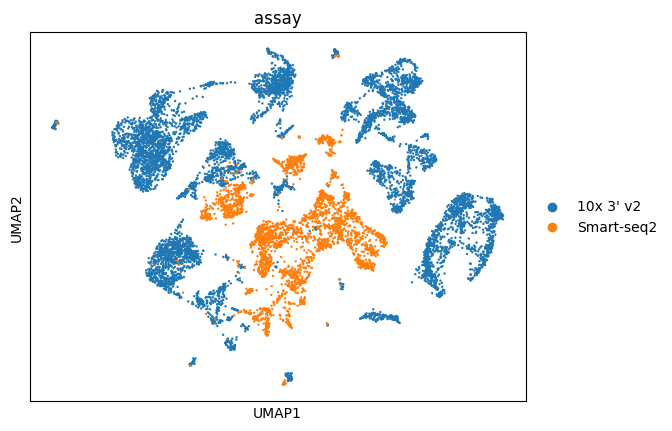

In [15]:
sc.pl.umap(adata, color="assay")

/home/bruce/projects/cellxgene-census/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


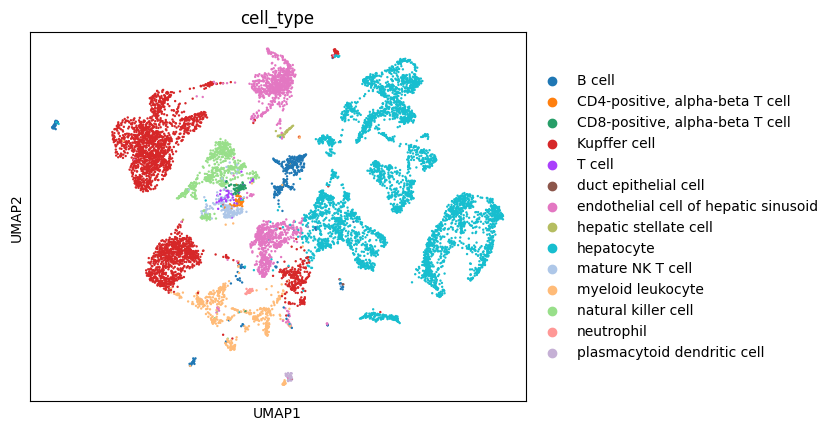

In [16]:
sc.pl.umap(adata, color="cell_type")

You can see that **batch effects are strong** as cells cluster primarily by `assay` and then by `cell_type`. Properly integrated embedding would in principle cluster primarily by `cell_type`, `assay` should at best randomly distributed. 

### Data integration with scVI

Whenever you query and fetch Census data from multiple datasets then integration needs to be performed as evidenced by the batch effects we observed.

**The paramaters for SCVI used in this notebook were selected to the model run quickly.** For best practices on integration of single-cell data using [`scvi-tools`](https://docs.scvi-tools.org/en/stable/index.html) please refer to their documentation page. 

Additionally we recommend reading the article [An integrated cell atlas of the human lung in health and disease](https://www.biorxiv.org/content/10.1101/2022.03.10.483747v1) by Sikkema et al. whom perfomed integration of 43 datasets from Lung.

Here we focus on the metadata from the Census that can be as batch information for integration.

#### Integration with batch defined as `dataset_id`

All cells in the Census are annotated with the dataset they come from in `obs["dataset_id"]`. This is a great place to start for integration.

So let's run an scVI model and obtain the latent embeddings. First we define our model with batch set as `dataset_id`.

In [17]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="dataset_id")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb", n_hidden=50)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Now let's train the model with default parameters.

In [18]:
vae.train(max_epochs=100)

/home/bruce/projects/cellxgene-census/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/bruce/projects/cellxgene-census/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:651: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.13it/s, loss=567, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s, loss=567, v_num=1]


And finally let's get the latent representations as cell embeddings and use those for UMAP visualization.

In [19]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

/home/bruce/projects/cellxgene-census/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


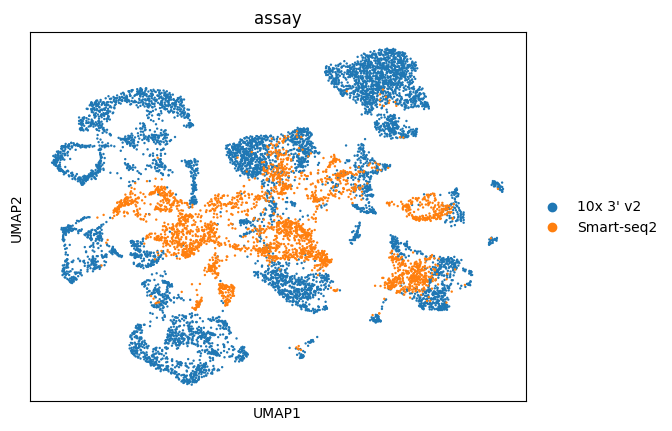

In [20]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
sc.pl.umap(adata, color="assay")

/home/bruce/projects/cellxgene-census/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


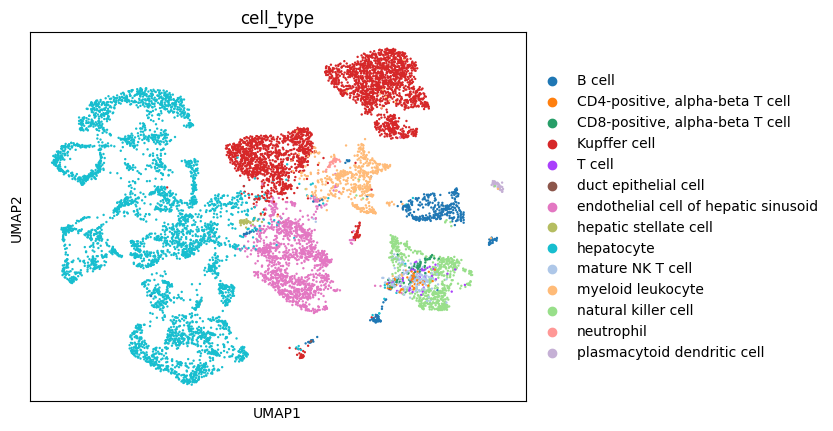

In [21]:
sc.pl.umap(adata, color="cell_type")

Great! You can see that the clustering is no longer mainly driven by assay, albeit still contributing to it.


#### Integration with batch defined as `dataset_id` + `donor_id`

Similar to `dataset_id`, all cells in Census are annotated with `donor_id`. The definition of `donor_id` depends on the dataset and it is left to the discretion of data curators. However it is still rich in information and can be used as a batch variable during integration.

Because `donor_id` is not guaranteed to be unique across all cells of the Census, we strongly recommend concatenating `dataset_id` and `donor_id` and use that as the batch key for scVI.

In [22]:
adata.obs["dataset_id_donor_id"] = adata.obs["dataset_id"].astype("str") + adata.obs["donor_id"].astype("str")

In [23]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="dataset_id_donor_id")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb", n_hidden=50)

Now we can train the model with the new batch definition.

In [24]:
vae.train(max_epochs=100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.10it/s, loss=552, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s, loss=552, v_num=1]


And we get the latent variables as embeddings.

In [25]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

/home/bruce/projects/cellxgene-census/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


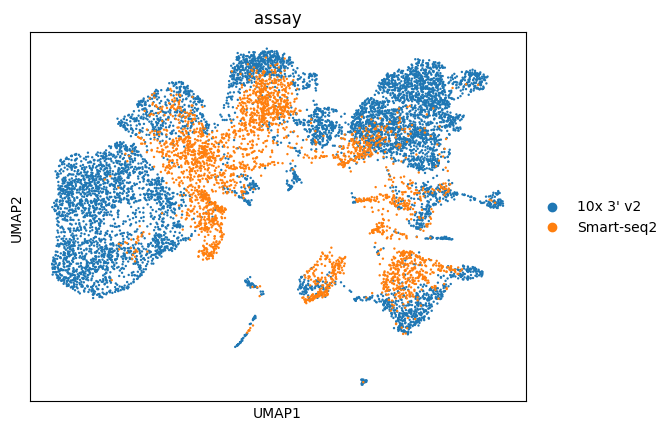

In [26]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
sc.pl.umap(adata, color="assay")

/home/bruce/projects/cellxgene-census/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


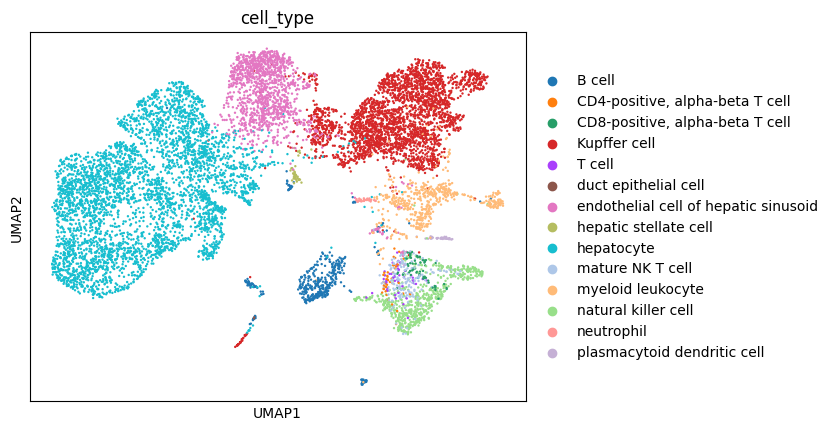

In [27]:
sc.pl.umap(adata, color="cell_type")

As you can see using `dataset_id` and `donor_id` as batch the cells now mostly cluster by cell type. 

#### Integration with batch defined as `dataset_id` + `donor_id` + `assay_ontology_term_id` + `suspension_type`

In some cases one dataset may contain multiple assay types and/or multiple suspension types (cell vs nucleus), and for those it is important to consider these metadata as batches. 

Therefore, the most comprehensive definition of batch in the Census can be accomplished by combining the cell metadata of `dataset_id`, `donor_id`, `assay_ontology_term_id` and `suspension_type`, the latter will encode the `EFO` ids for assay types.

In our example, the two datasets that we used only contain cells from one assay each, and one suspension type for all of them. Thus it would not make a difference to include these metadata as part of batch.